In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
metric = "rmse"

In [4]:
nice_names = lambda name : name.replace("_", " ").capitalize()

In [5]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    xticks = None
    for label, xds in dsdict.items():
        
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        if xticks is None:
            xticks = plotme.fhr.values
        df = plotme.to_dataframe().reset_index()
        if label == "HRRR":
            color="gray"
        elif label == "GFS":
            color="black"
        else:
            color=None
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=color,
            **kwargs,
        )
    xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
        title=nice_names(varname) if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
    )
    ax.legend(frameon=False)

In [6]:
def plot_surface_error(surface_vars, dsdict, model_filter=None, **kwargs):
    ncols = len(surface_vars)
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4), constrained_layout=True)

    if len(surface_vars) == 1:
        axs = [axs]
    for varname, ax in zip(surface_vars, axs):
        single_plot(ax=ax, dsdict=dsdict, varname=varname, **kwargs)
    return fig, axs

In [7]:
def plot_level_vars(level_vars, dsdict, **kwargs):
    
    levels = dsdict["GFS"].level.values
    ncols = len(level_vars)
    nrows = len(levels)
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)

    if len(levels) == 1:
        axs = [axs]
    if len(level_vars) == 1:
        axs = [axs]

    sel = kwargs.pop("sel", {})
    for level, axr in zip(levels, axs):
        for varname, ax in zip(level_vars, axr):
            
            sel["level"] = level
            single_plot(ax=ax, dsdict=dsdict, varname=varname, sel=sel, **kwargs)
            ax.legend(title=f"{level} hPa", frameon=False)
    return fig, axs

In [8]:
surface_fields = ["surface_pressure", "10m_zonal_wind", "10m_meridional_wind", "2m_temperature", "2m_specific_humidity"]
pressure_fields = ["geopotential_height", "zonal_wind", "meridional_wind", "temperature", "specific_humidity"]

## Number of Initial Conditions

In [9]:
subregion = ".northern_hemisphere"
#subregion = ""
nic = {
    "two": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "one": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/nic/sic/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
}
    
nic["GFS"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)

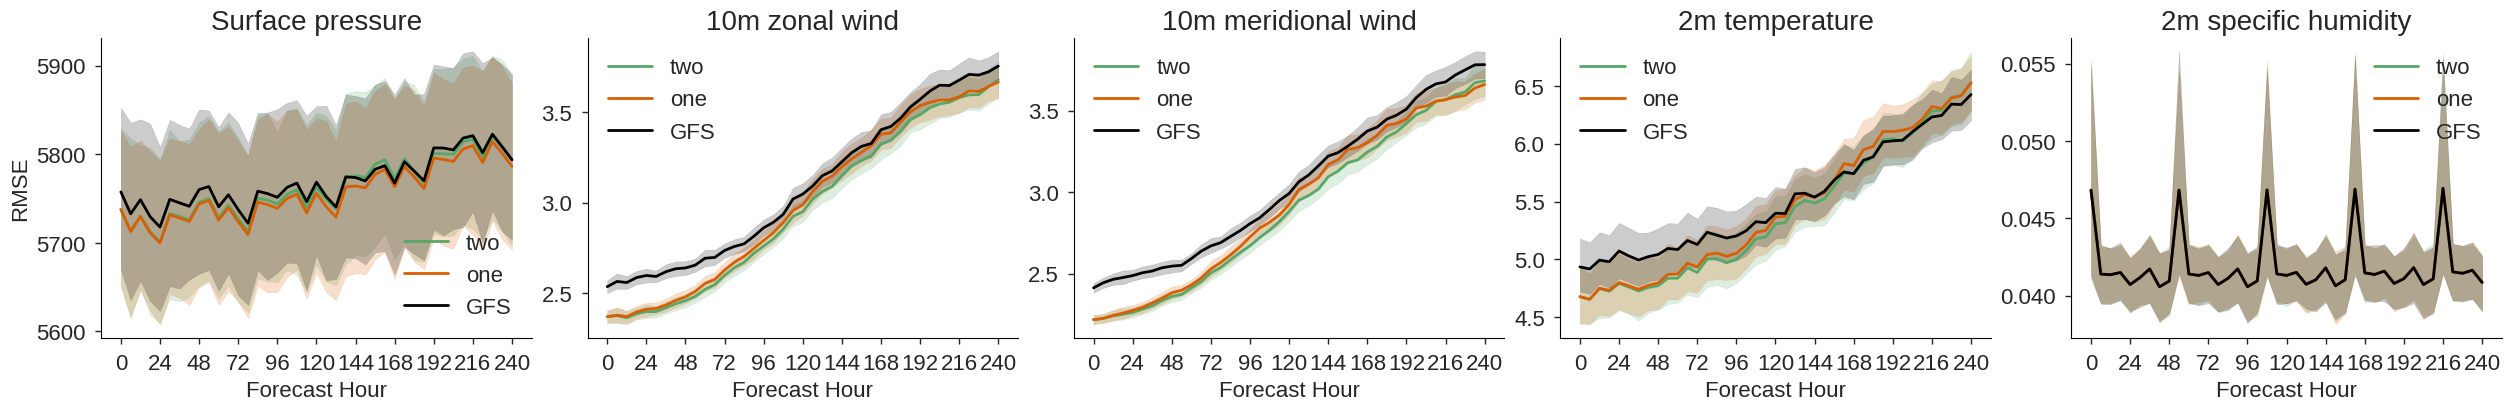

In [10]:
fig, axs = plot_surface_error(
    surface_fields,
    dsdict=nic,
)

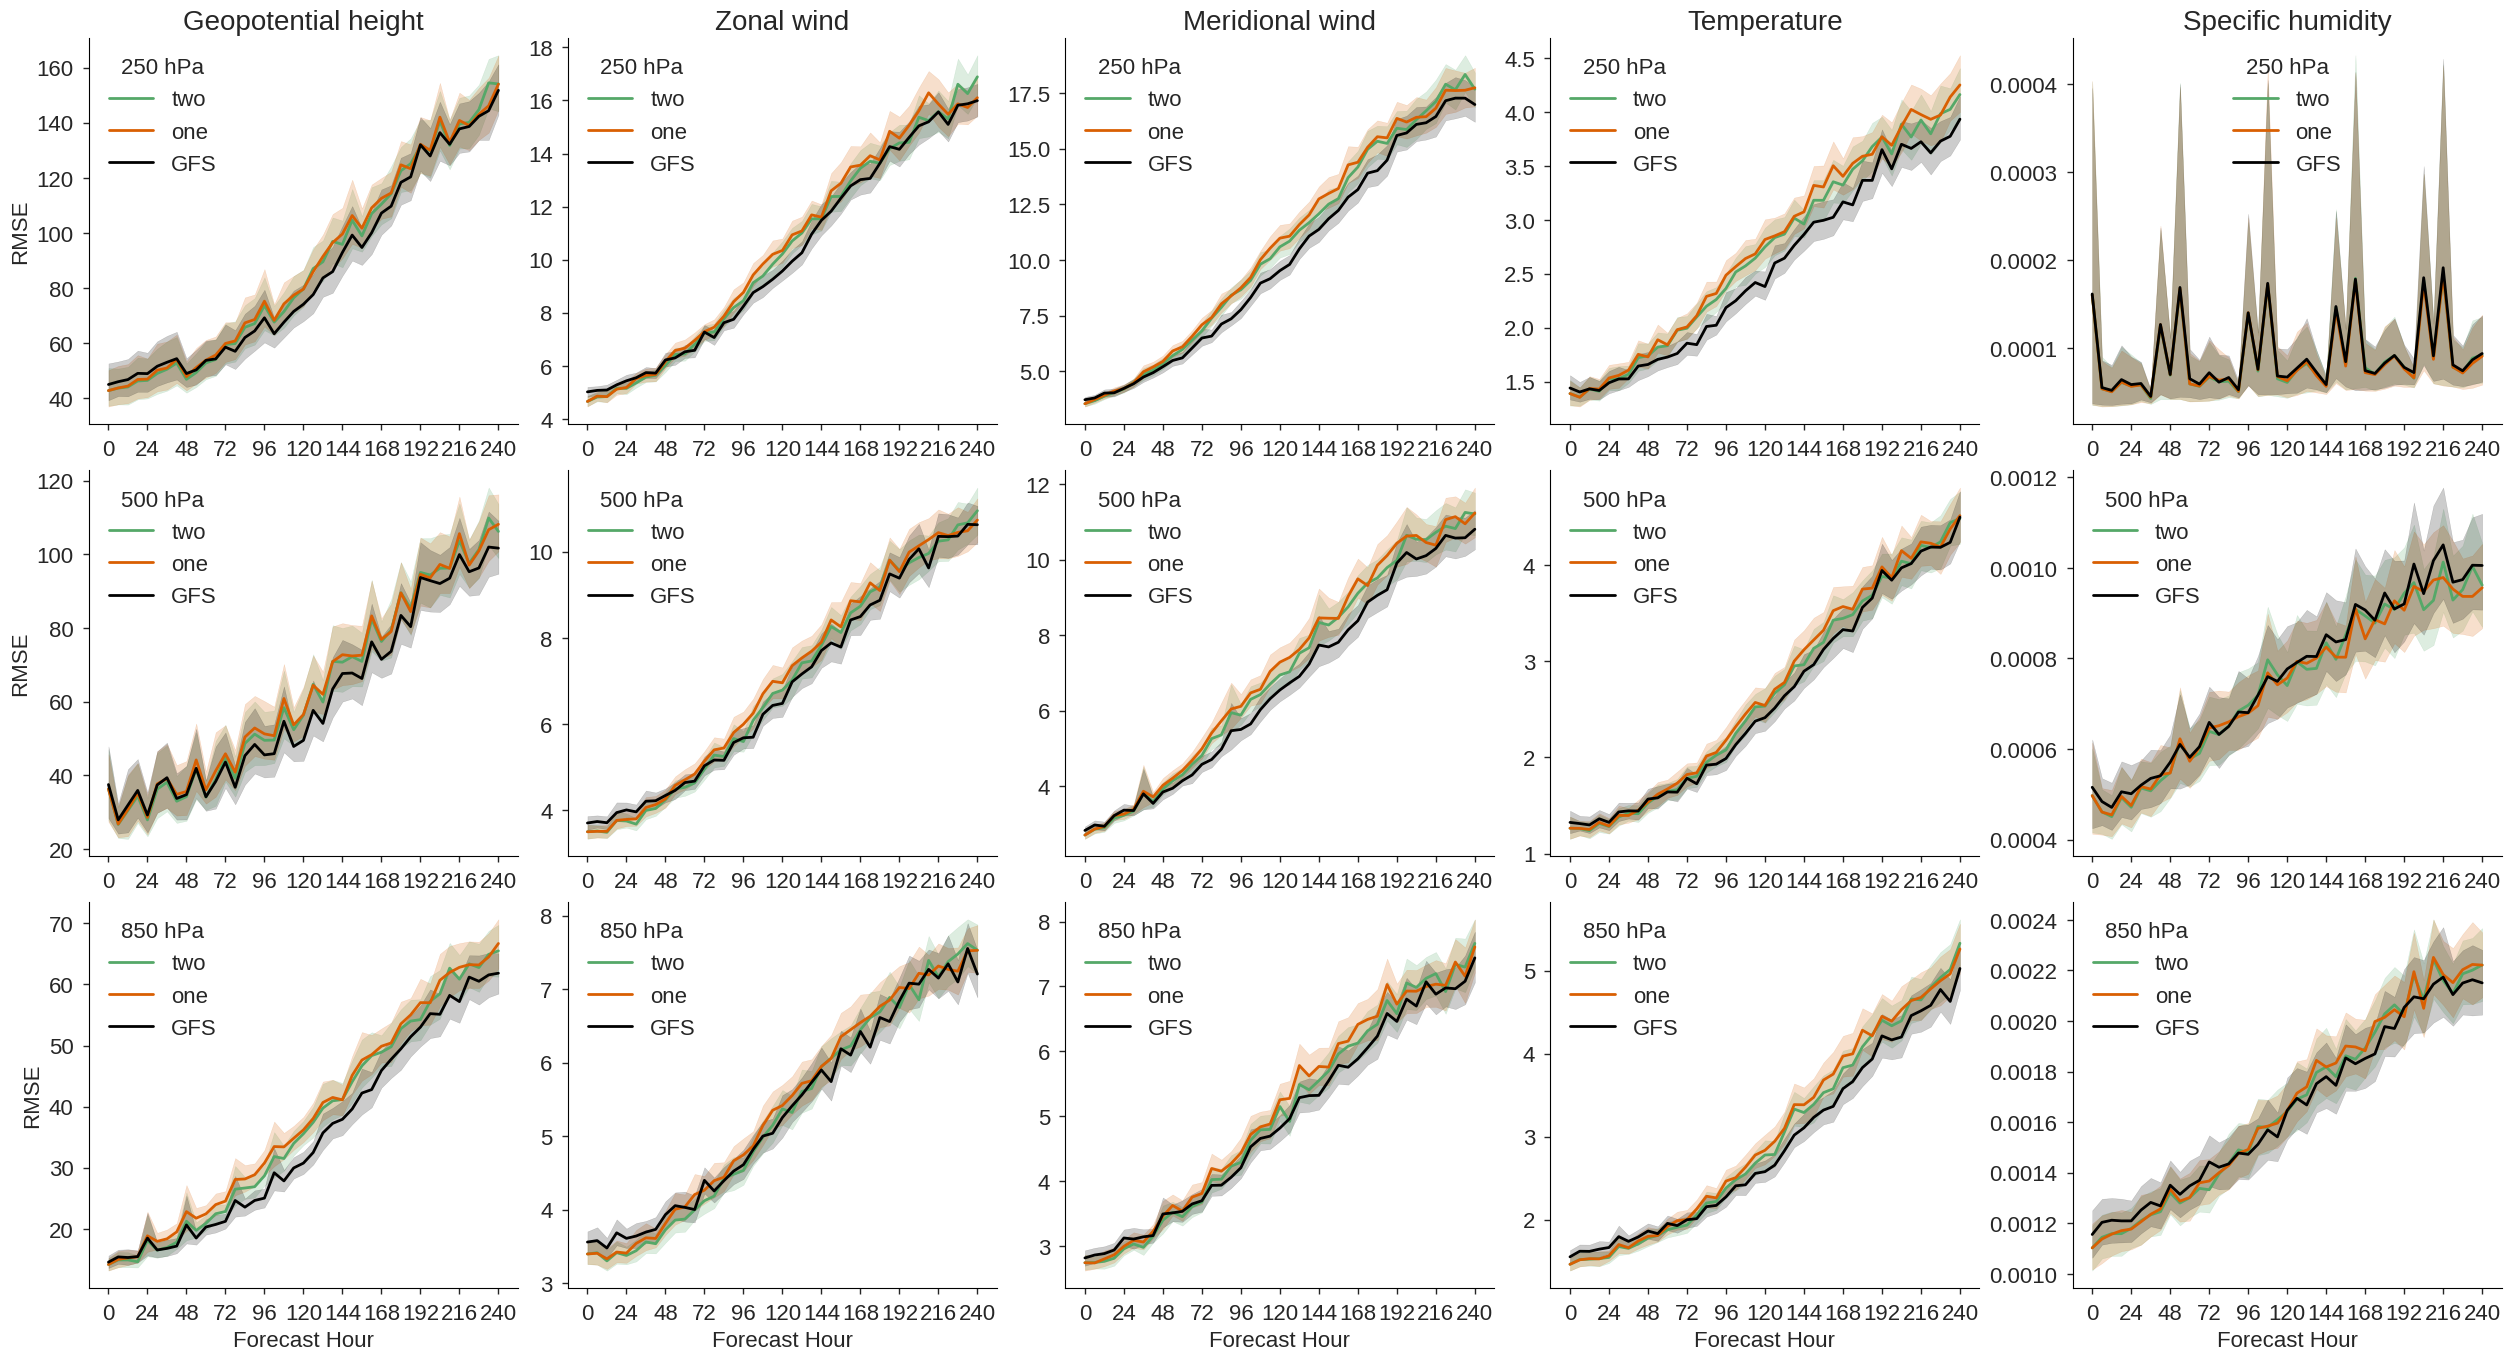

In [11]:
fig, axs = plot_level_vars(
    pressure_fields,
    dsdict=nic,
)

## Latent Space Updates

In [12]:
metric = "rmse"
subregion = ".northern_hemisphere"
#subregion = ""
latent = {
    "old": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/nic/sic/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "fixed": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/fixed/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "heal5": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/heal5/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "o48": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/o48/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
}
    
latent["GFS"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)

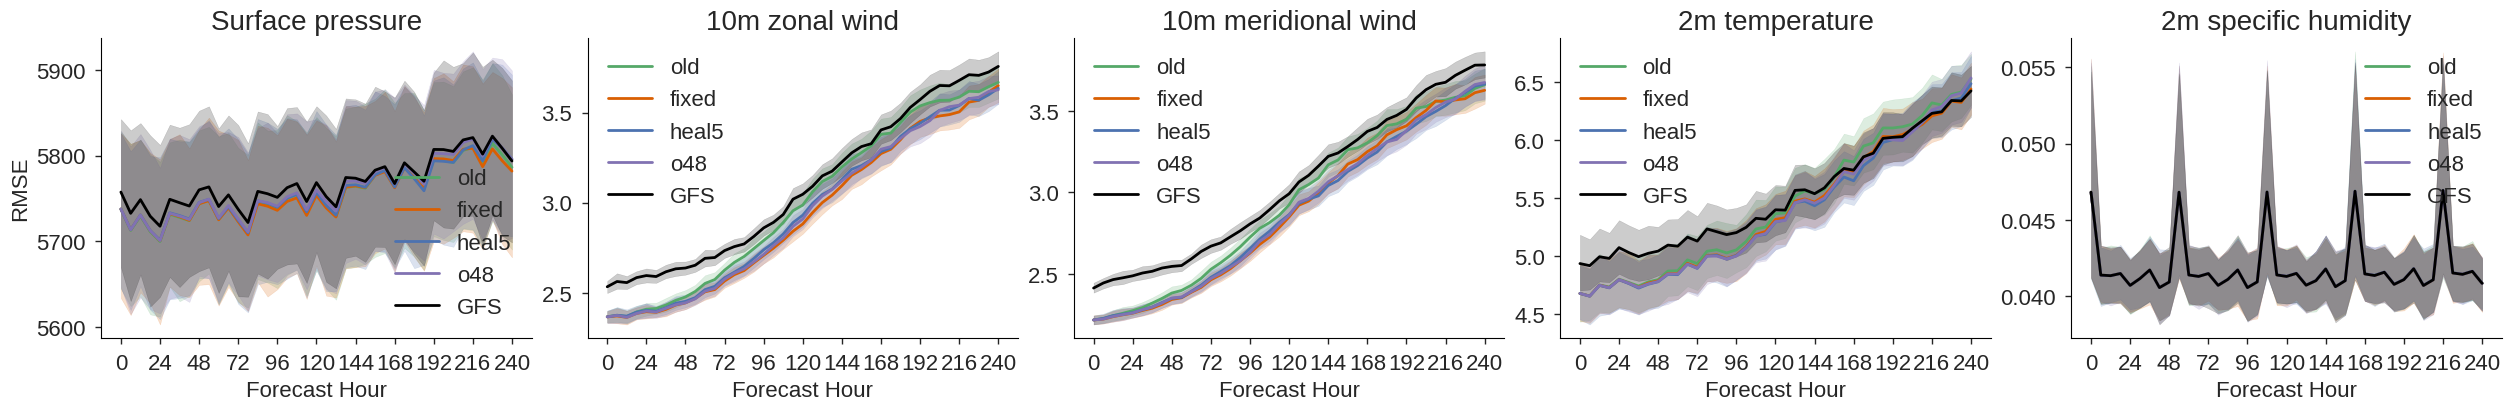

In [13]:
fig, axs = plot_surface_error(
    surface_fields,
    dsdict=latent,
)

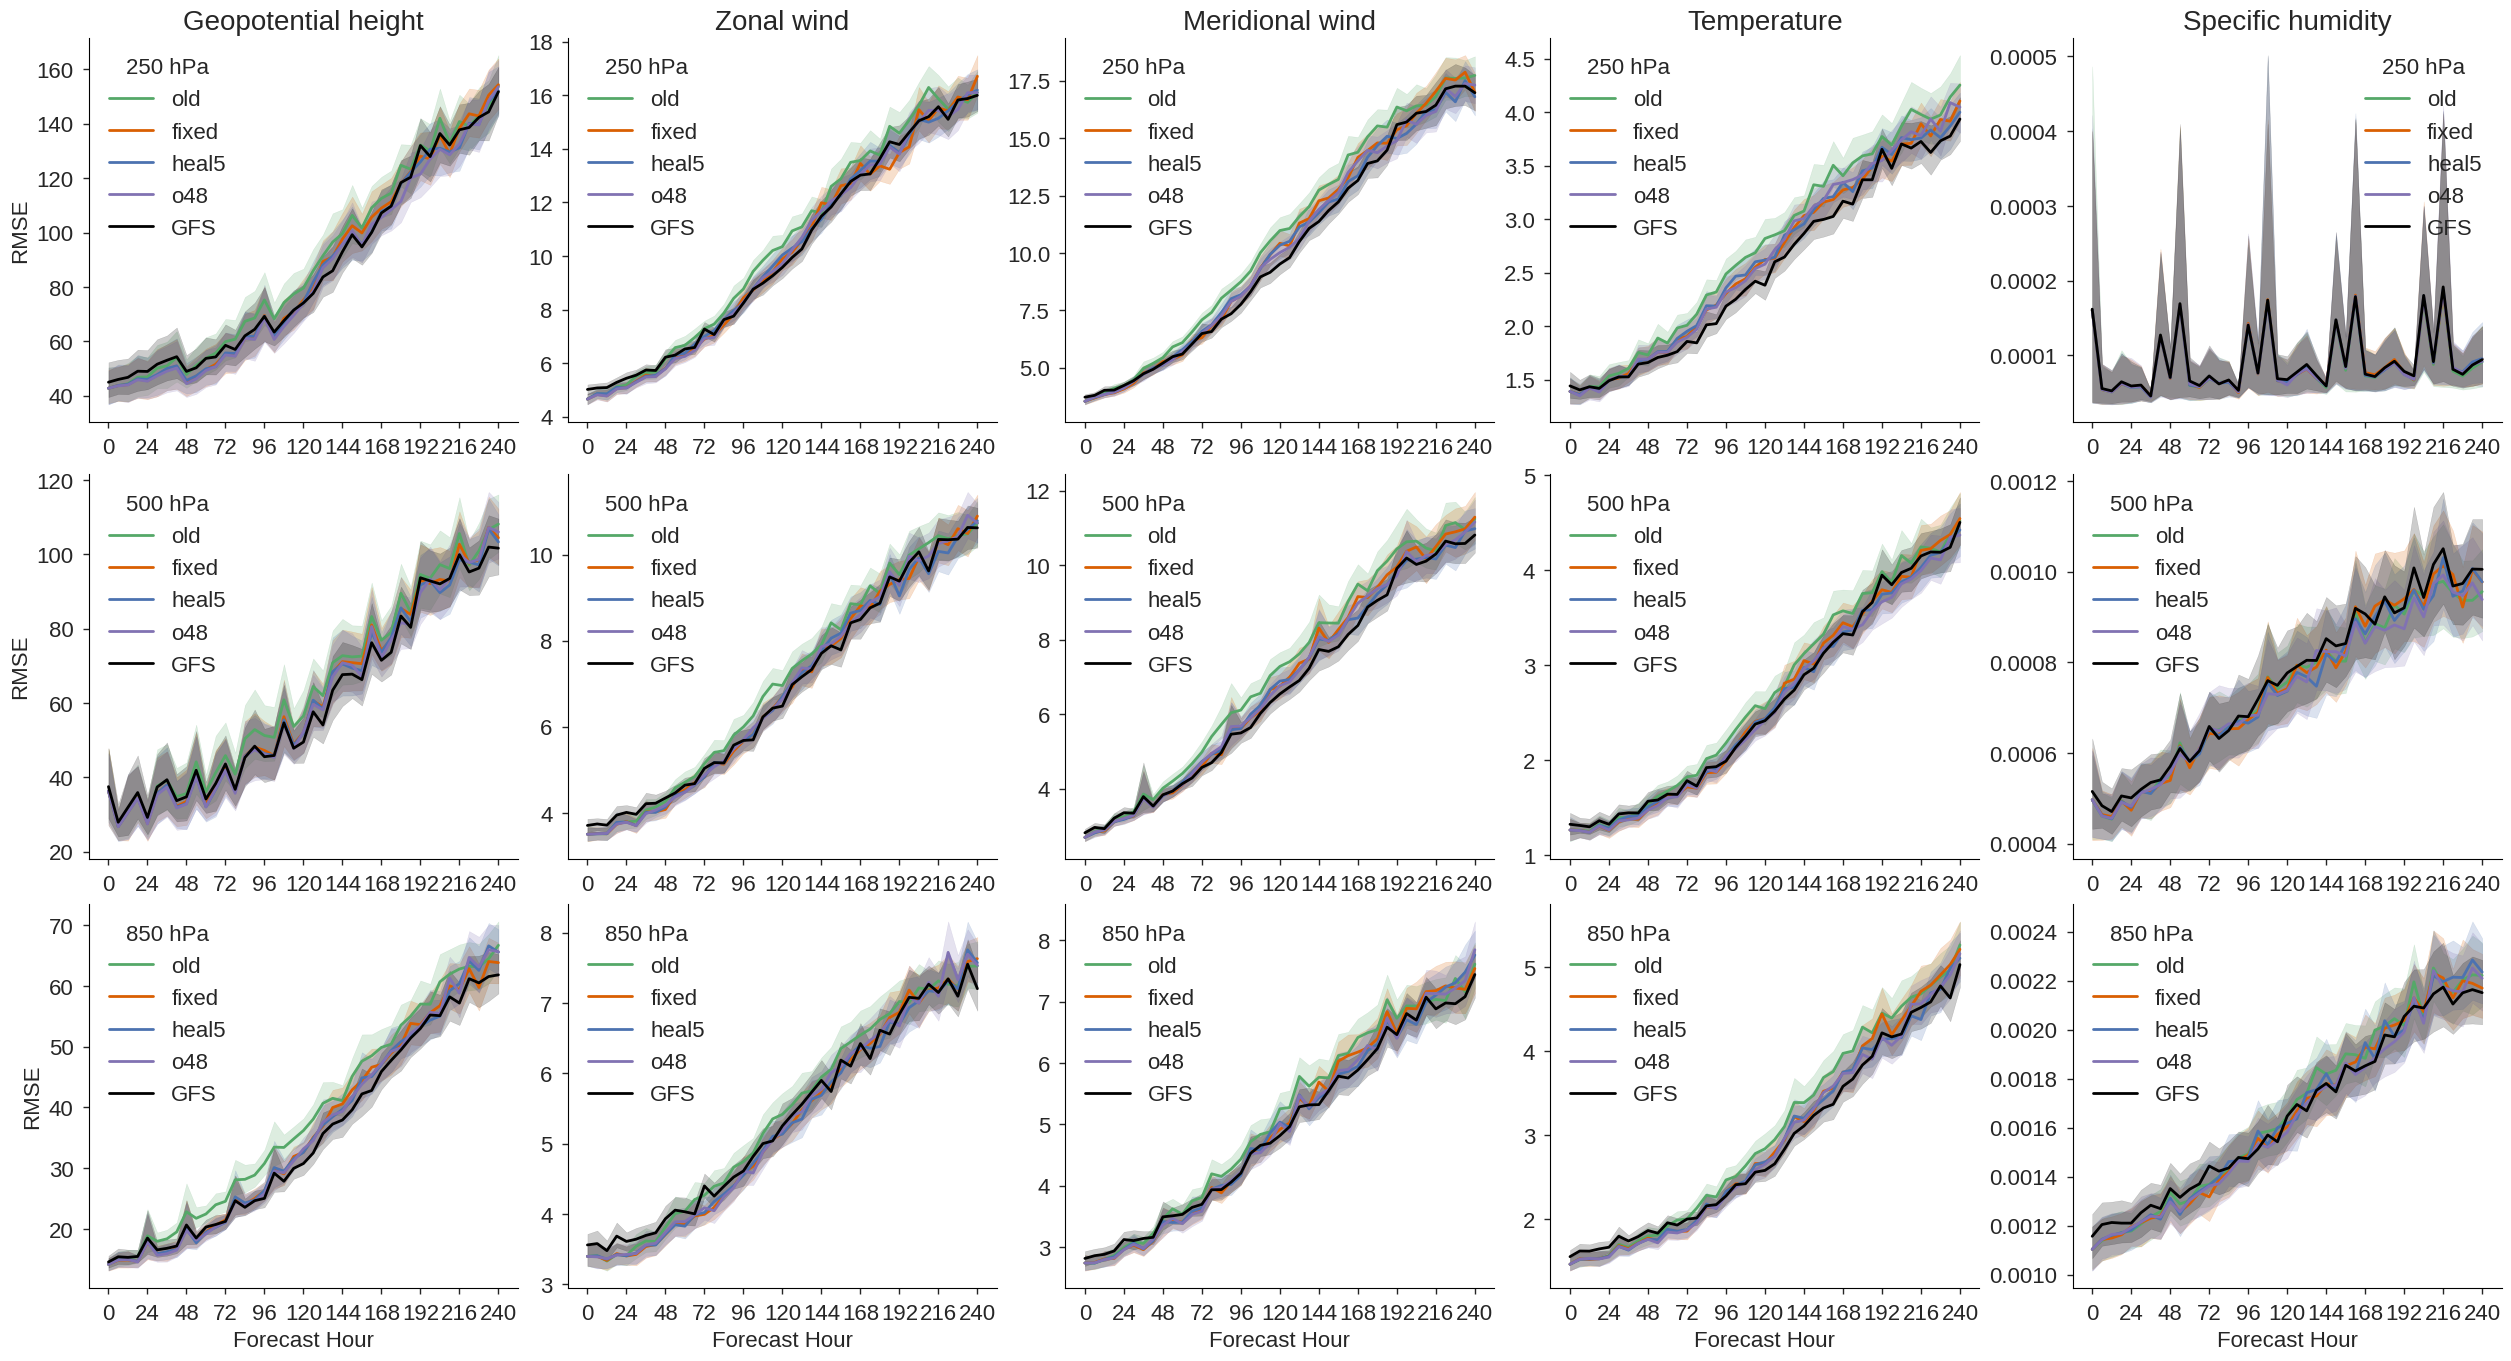

In [14]:
fig, axs = plot_level_vars(
    pressure_fields,
    dsdict=latent,
)

## Updated window size test, now that the latent space is fixed

In [15]:
metric = "rmse"
subregion = ".northern_hemisphere"
#subregion = ""
hwin = {
    "latlon win4320": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/fixed/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "win1080": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/fixed-window-size/win1080/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "win2160": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/fixed-window-size/win2160/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "win3564": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/fixed-window-size/win3564/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "win4320": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/heal5/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
}
    
hwin["GFS"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)

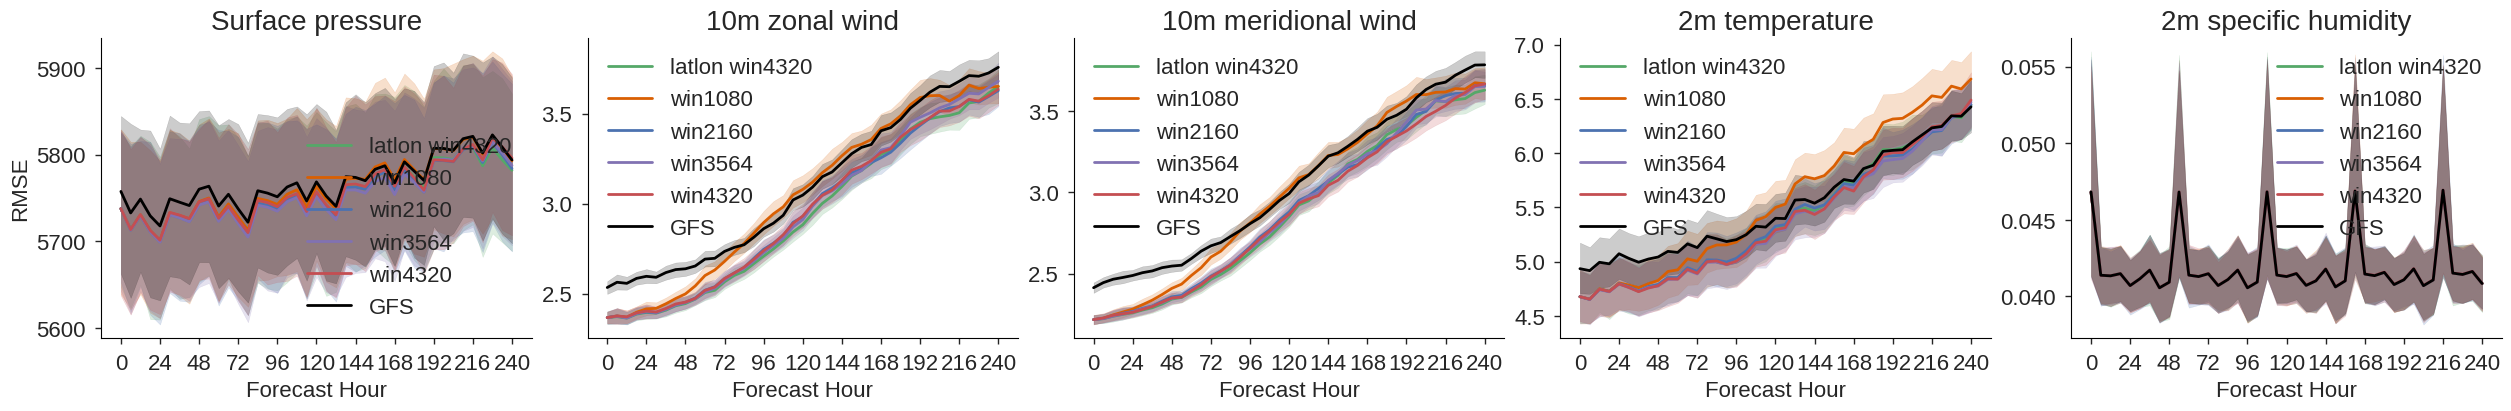

In [16]:
fig, axs = plot_surface_error(
    surface_fields,
    dsdict=hwin,
)

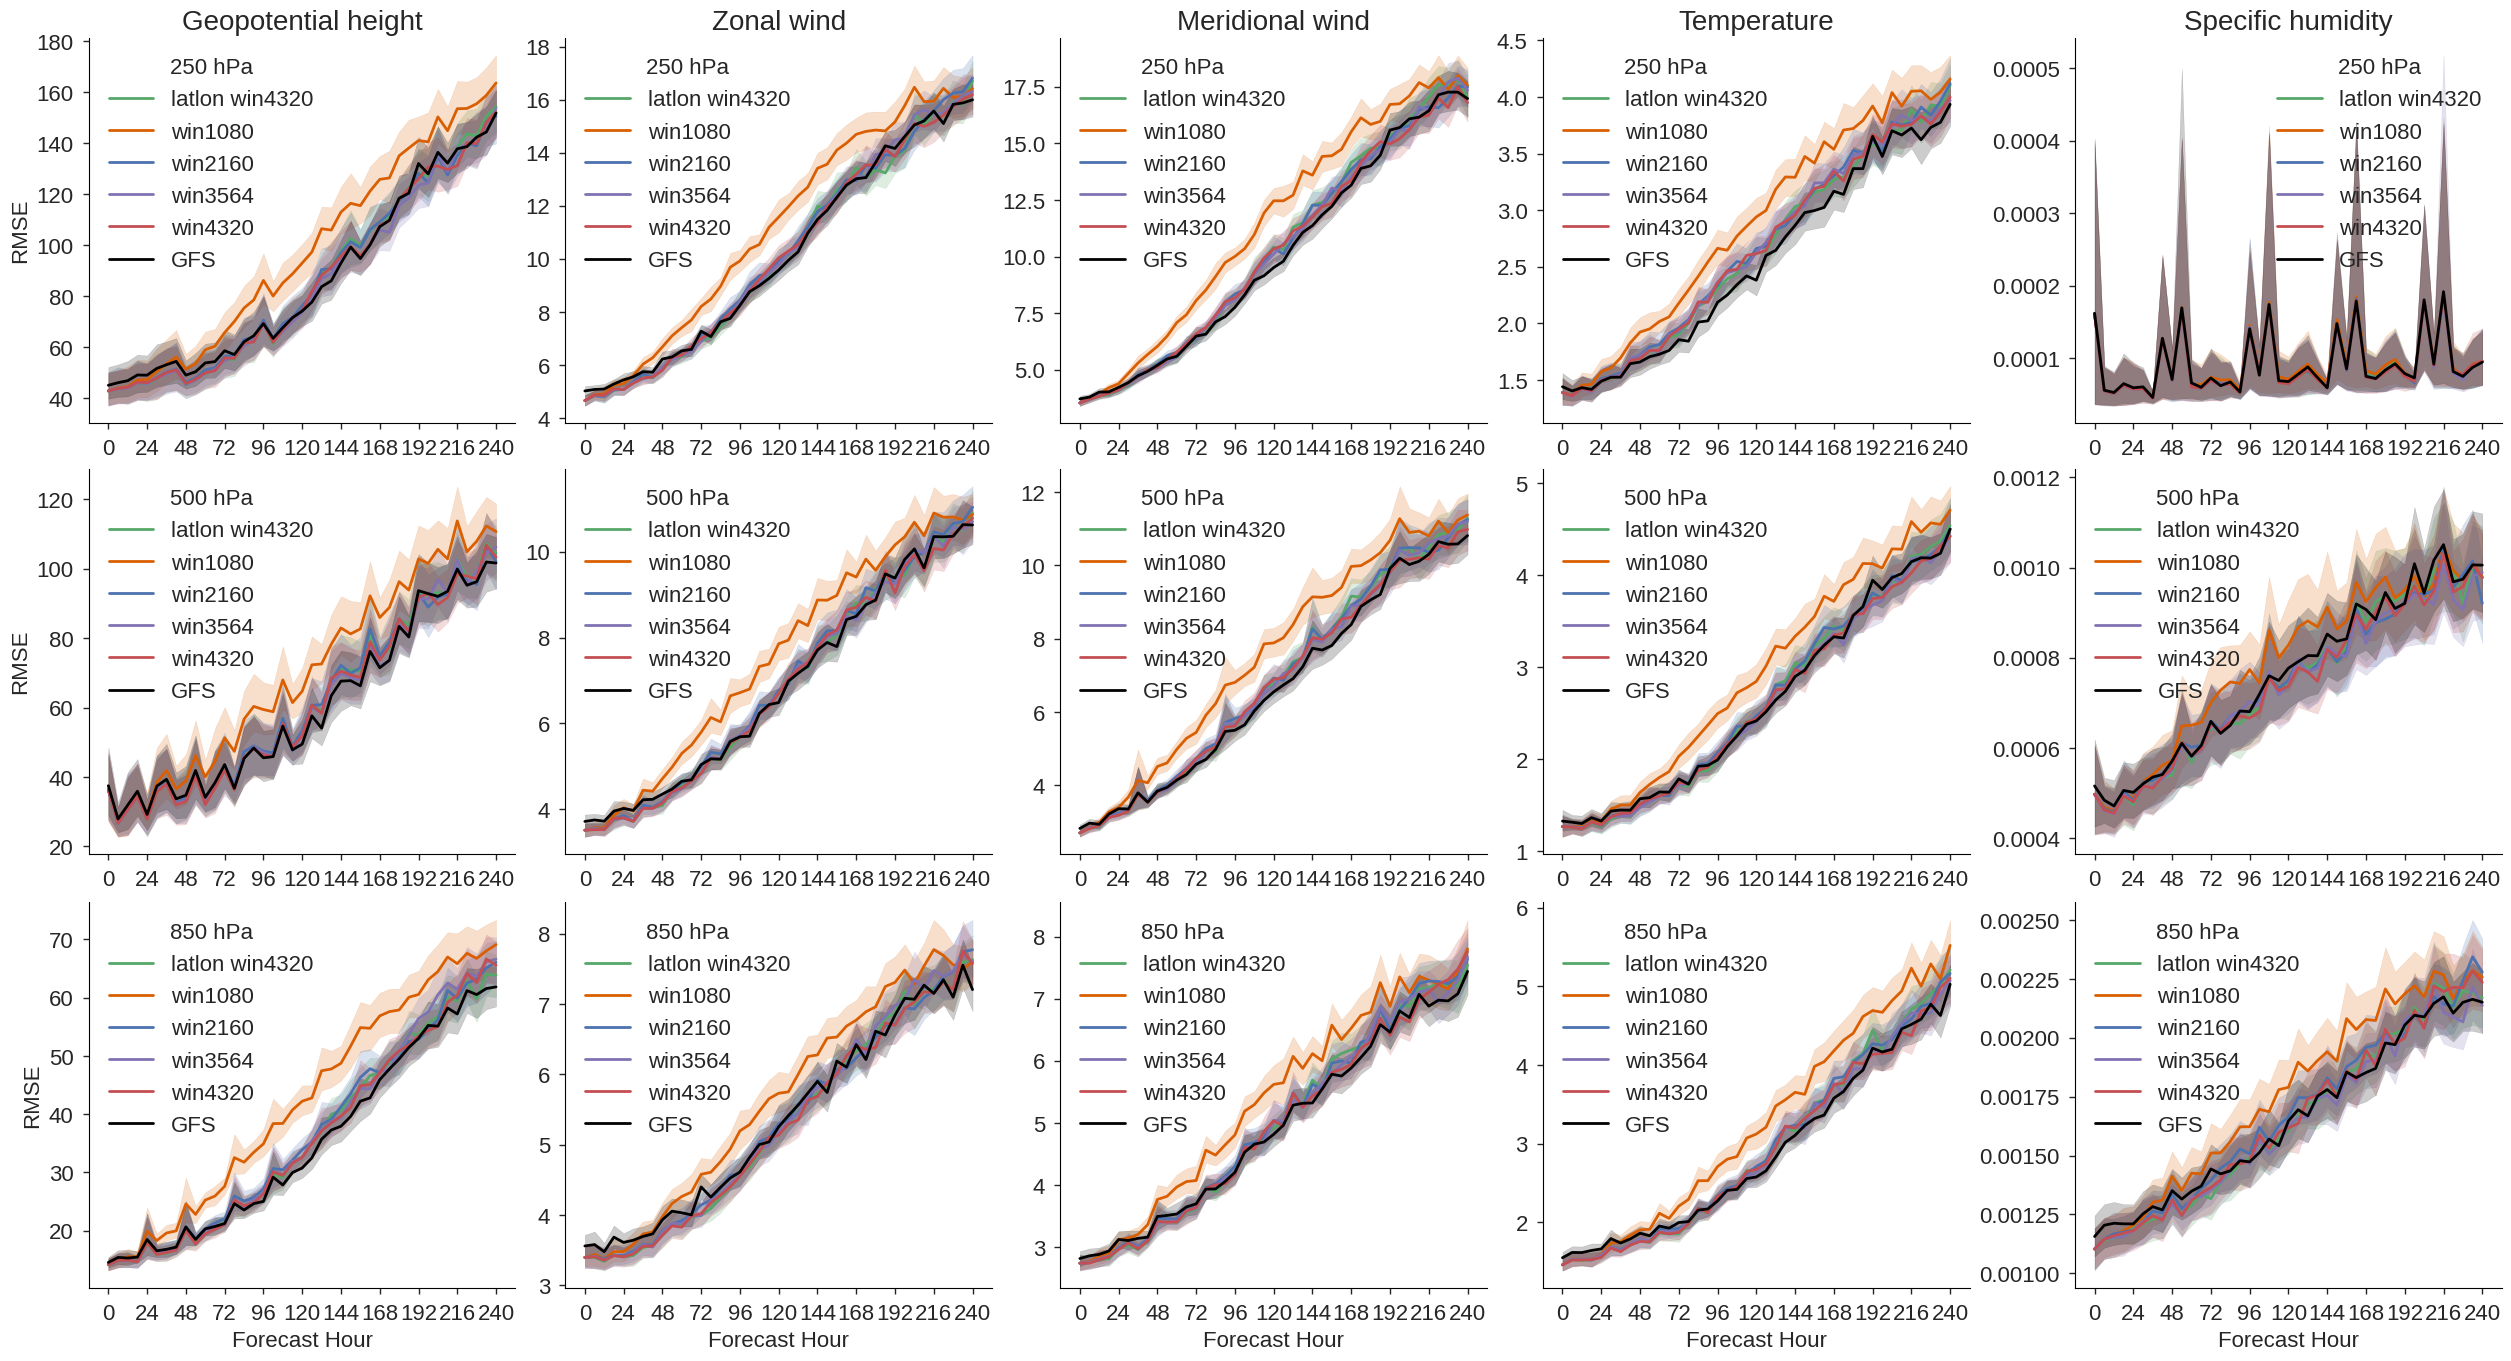

In [17]:
fig, axs = plot_level_vars(
    pressure_fields,
    dsdict=hwin,
)

## QK Norm

In [18]:
subregion = ".northern_hemisphere"
#subregion = ""
qknorm = {
    "none": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/latent-updates/heal5/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "processor": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/qknorm/pqk/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "all 3": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/qknorm/all/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
}
    
qknorm["GFS"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)

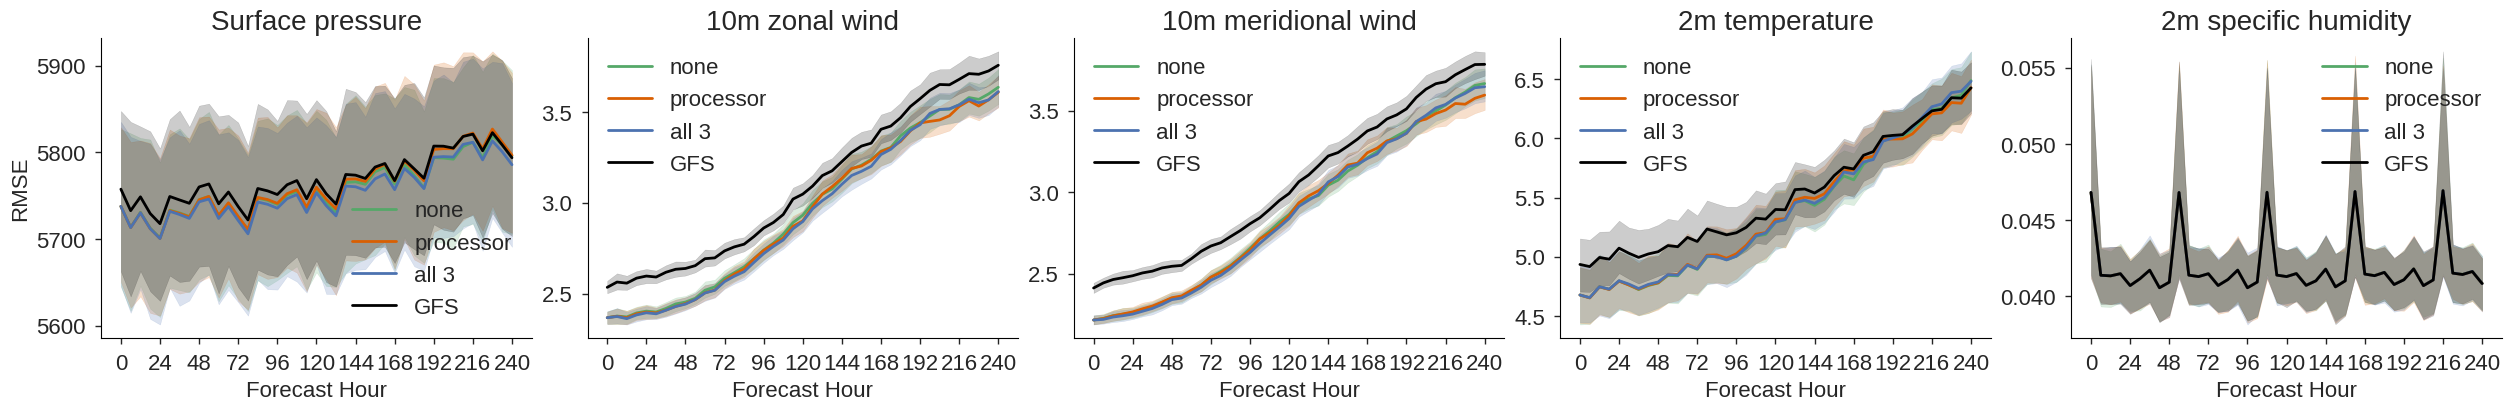

In [19]:
fig, axs = plot_surface_error(
    surface_fields,
    dsdict=qknorm,
)

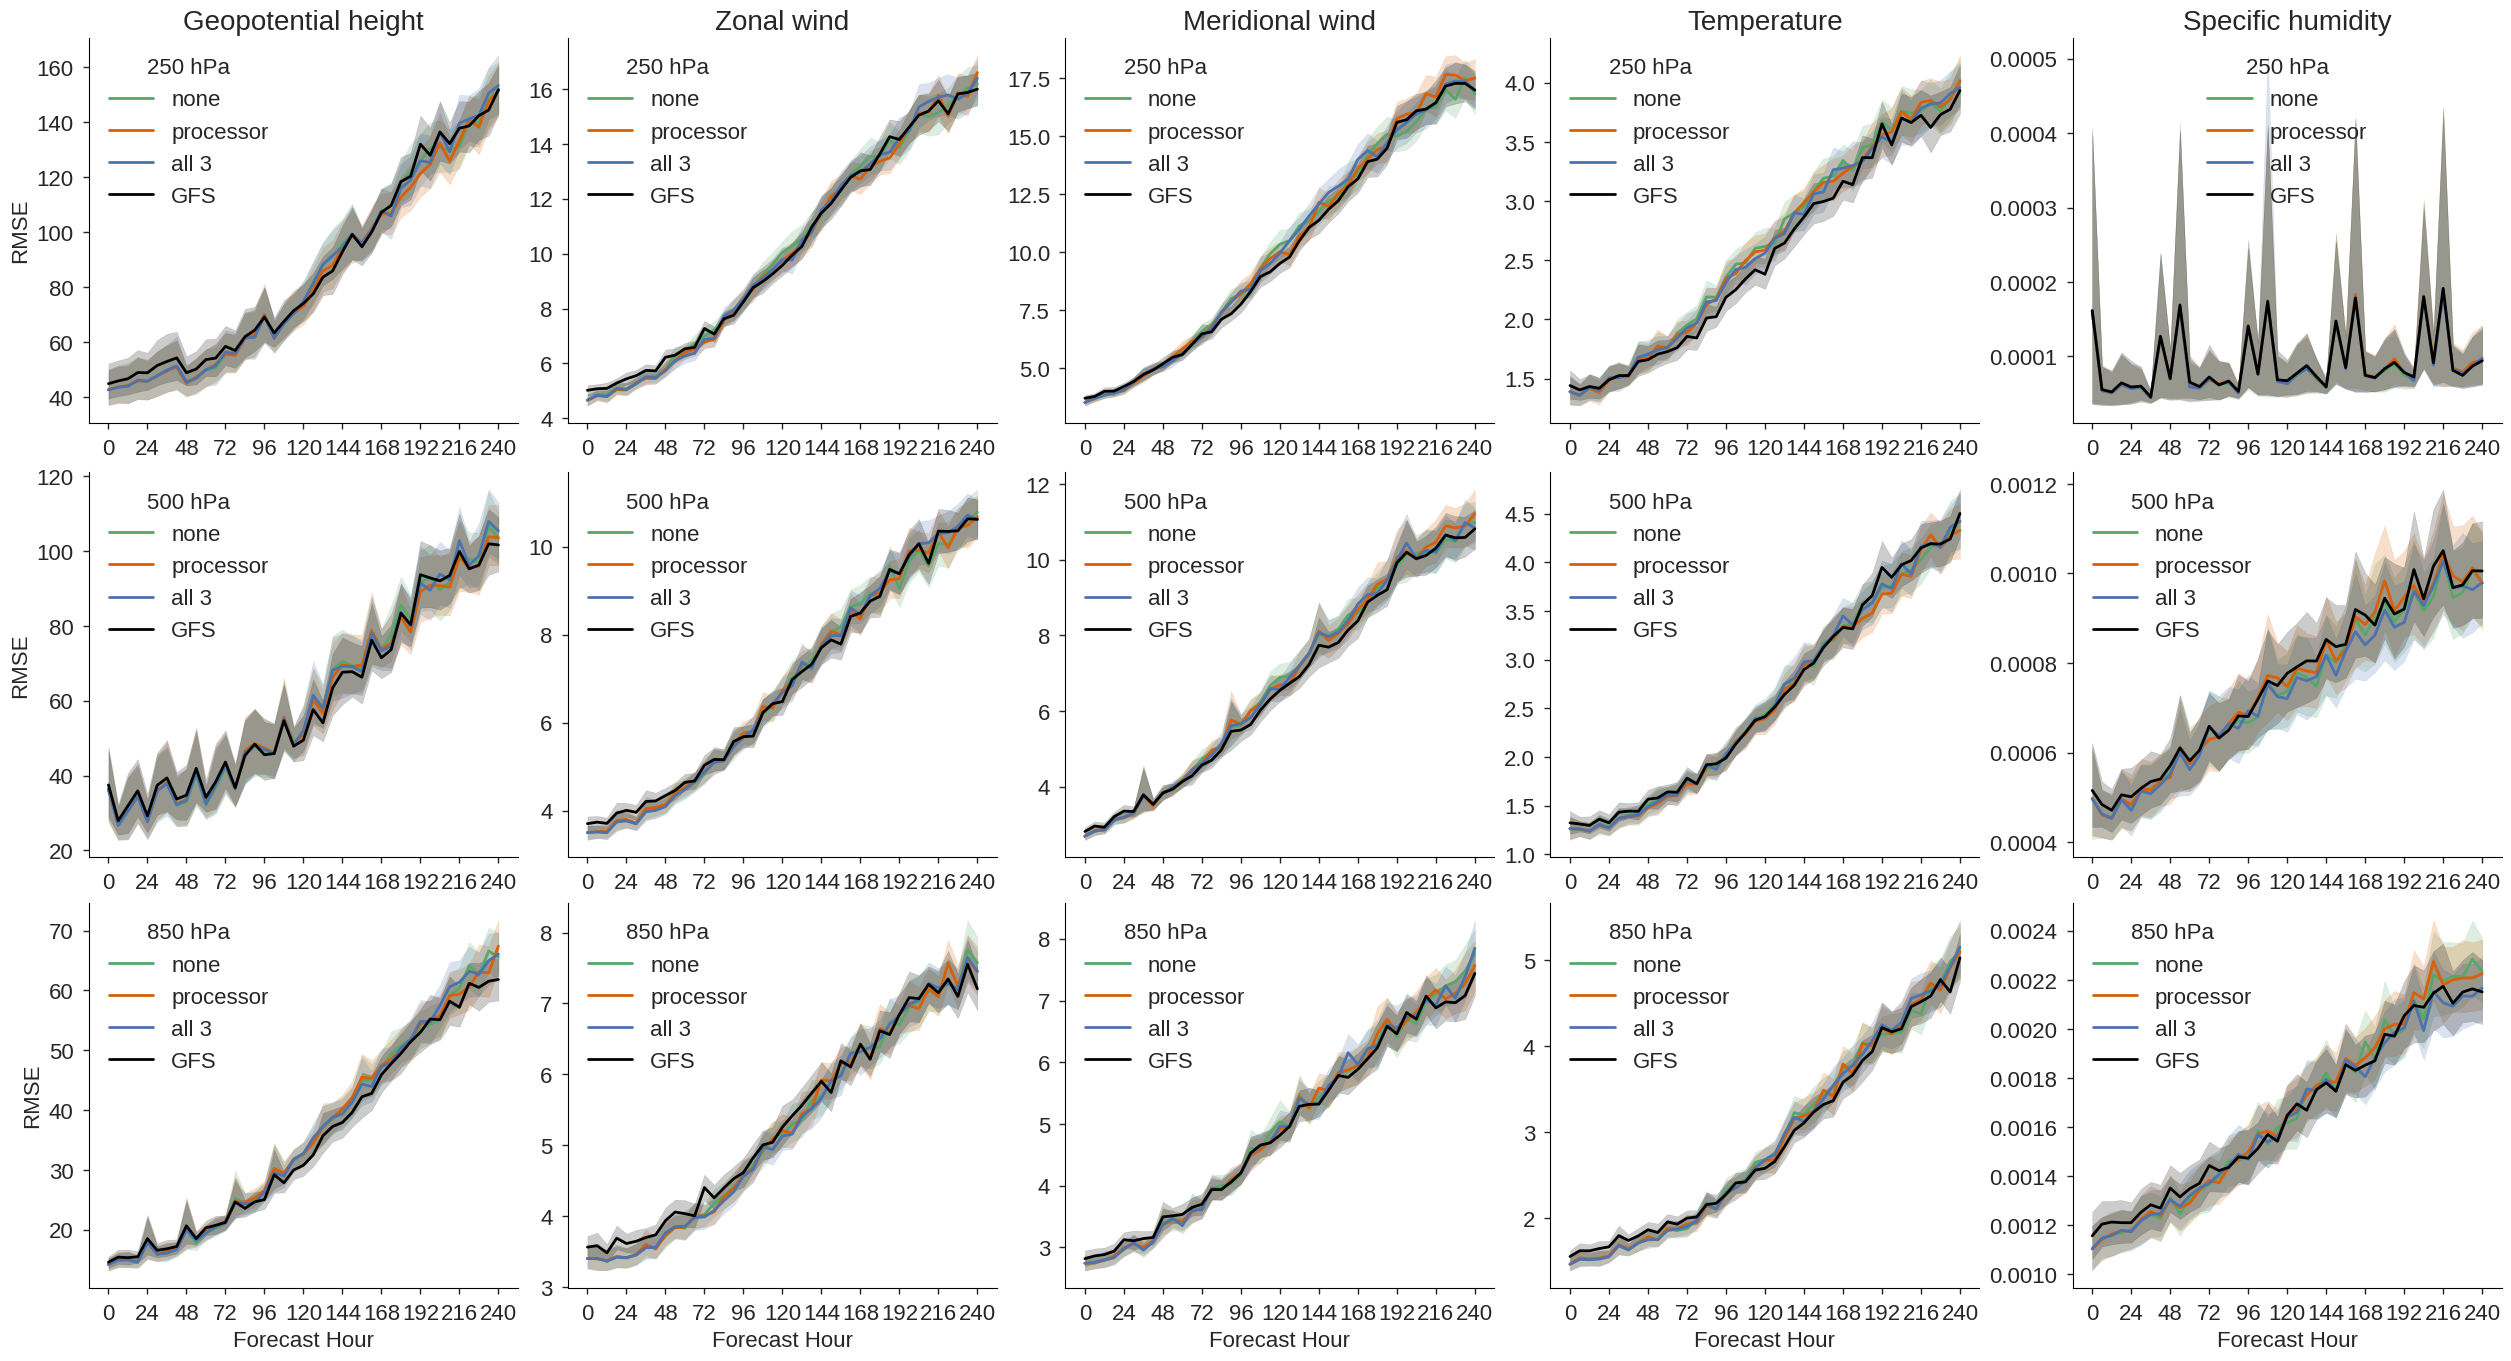

In [20]:
fig, axs = plot_level_vars(
    pressure_fields,
    dsdict=qknorm,
)

## Trainable Parameters

In [21]:
#subregion = ".europe"
subregion = ""
tp = {
    "eight": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/fixed-window-size/win3564/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
    "zero": xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/trainable-parameters/zero/inference-validation/obs-metrics/{metric}.convobs.nested-global{subregion}.nc", decode_timedelta=False),
}
    
tp["GFS"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/gfs-forecasts-vs-gfs-analysis/obs-metrics/{metric}.convobs.global{subregion}.nc", decode_timedelta=True)

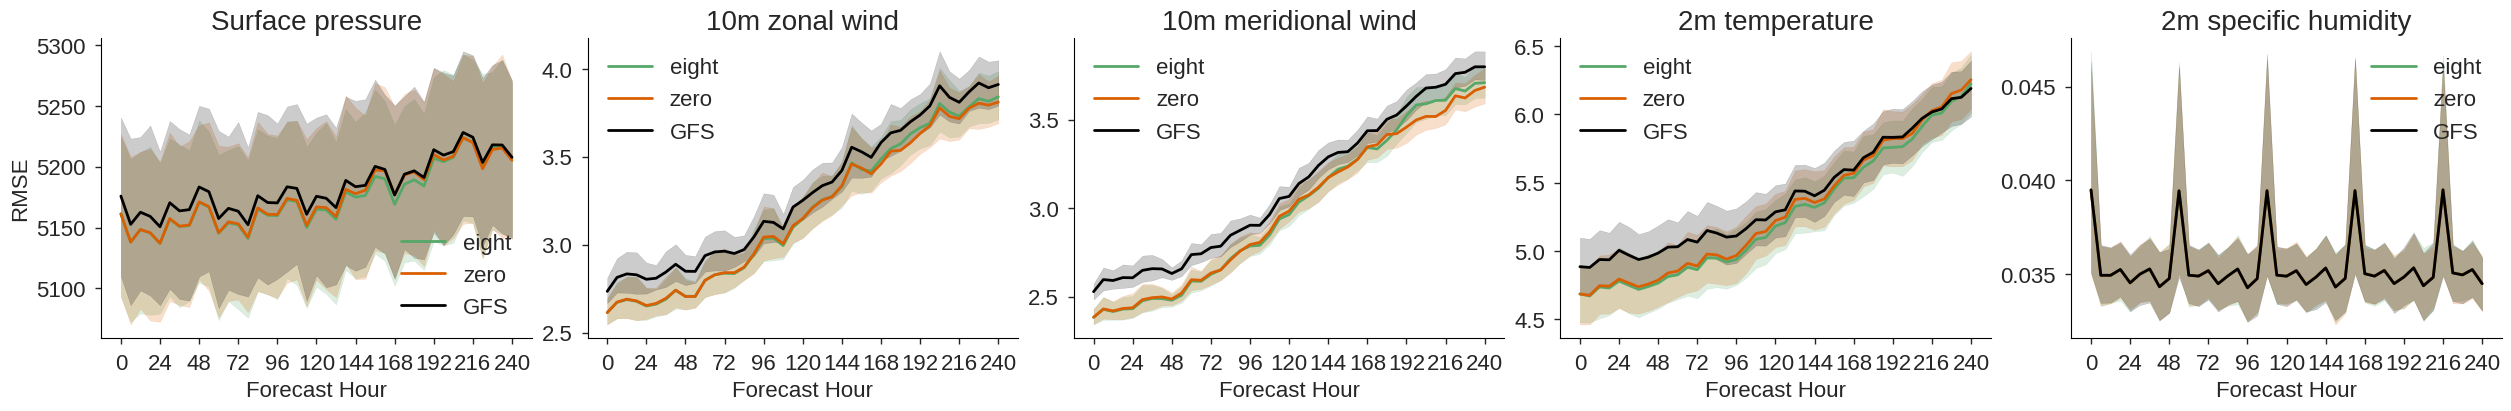

In [22]:
fig, axs = plot_surface_error(
    surface_fields,
    dsdict=tp,
)

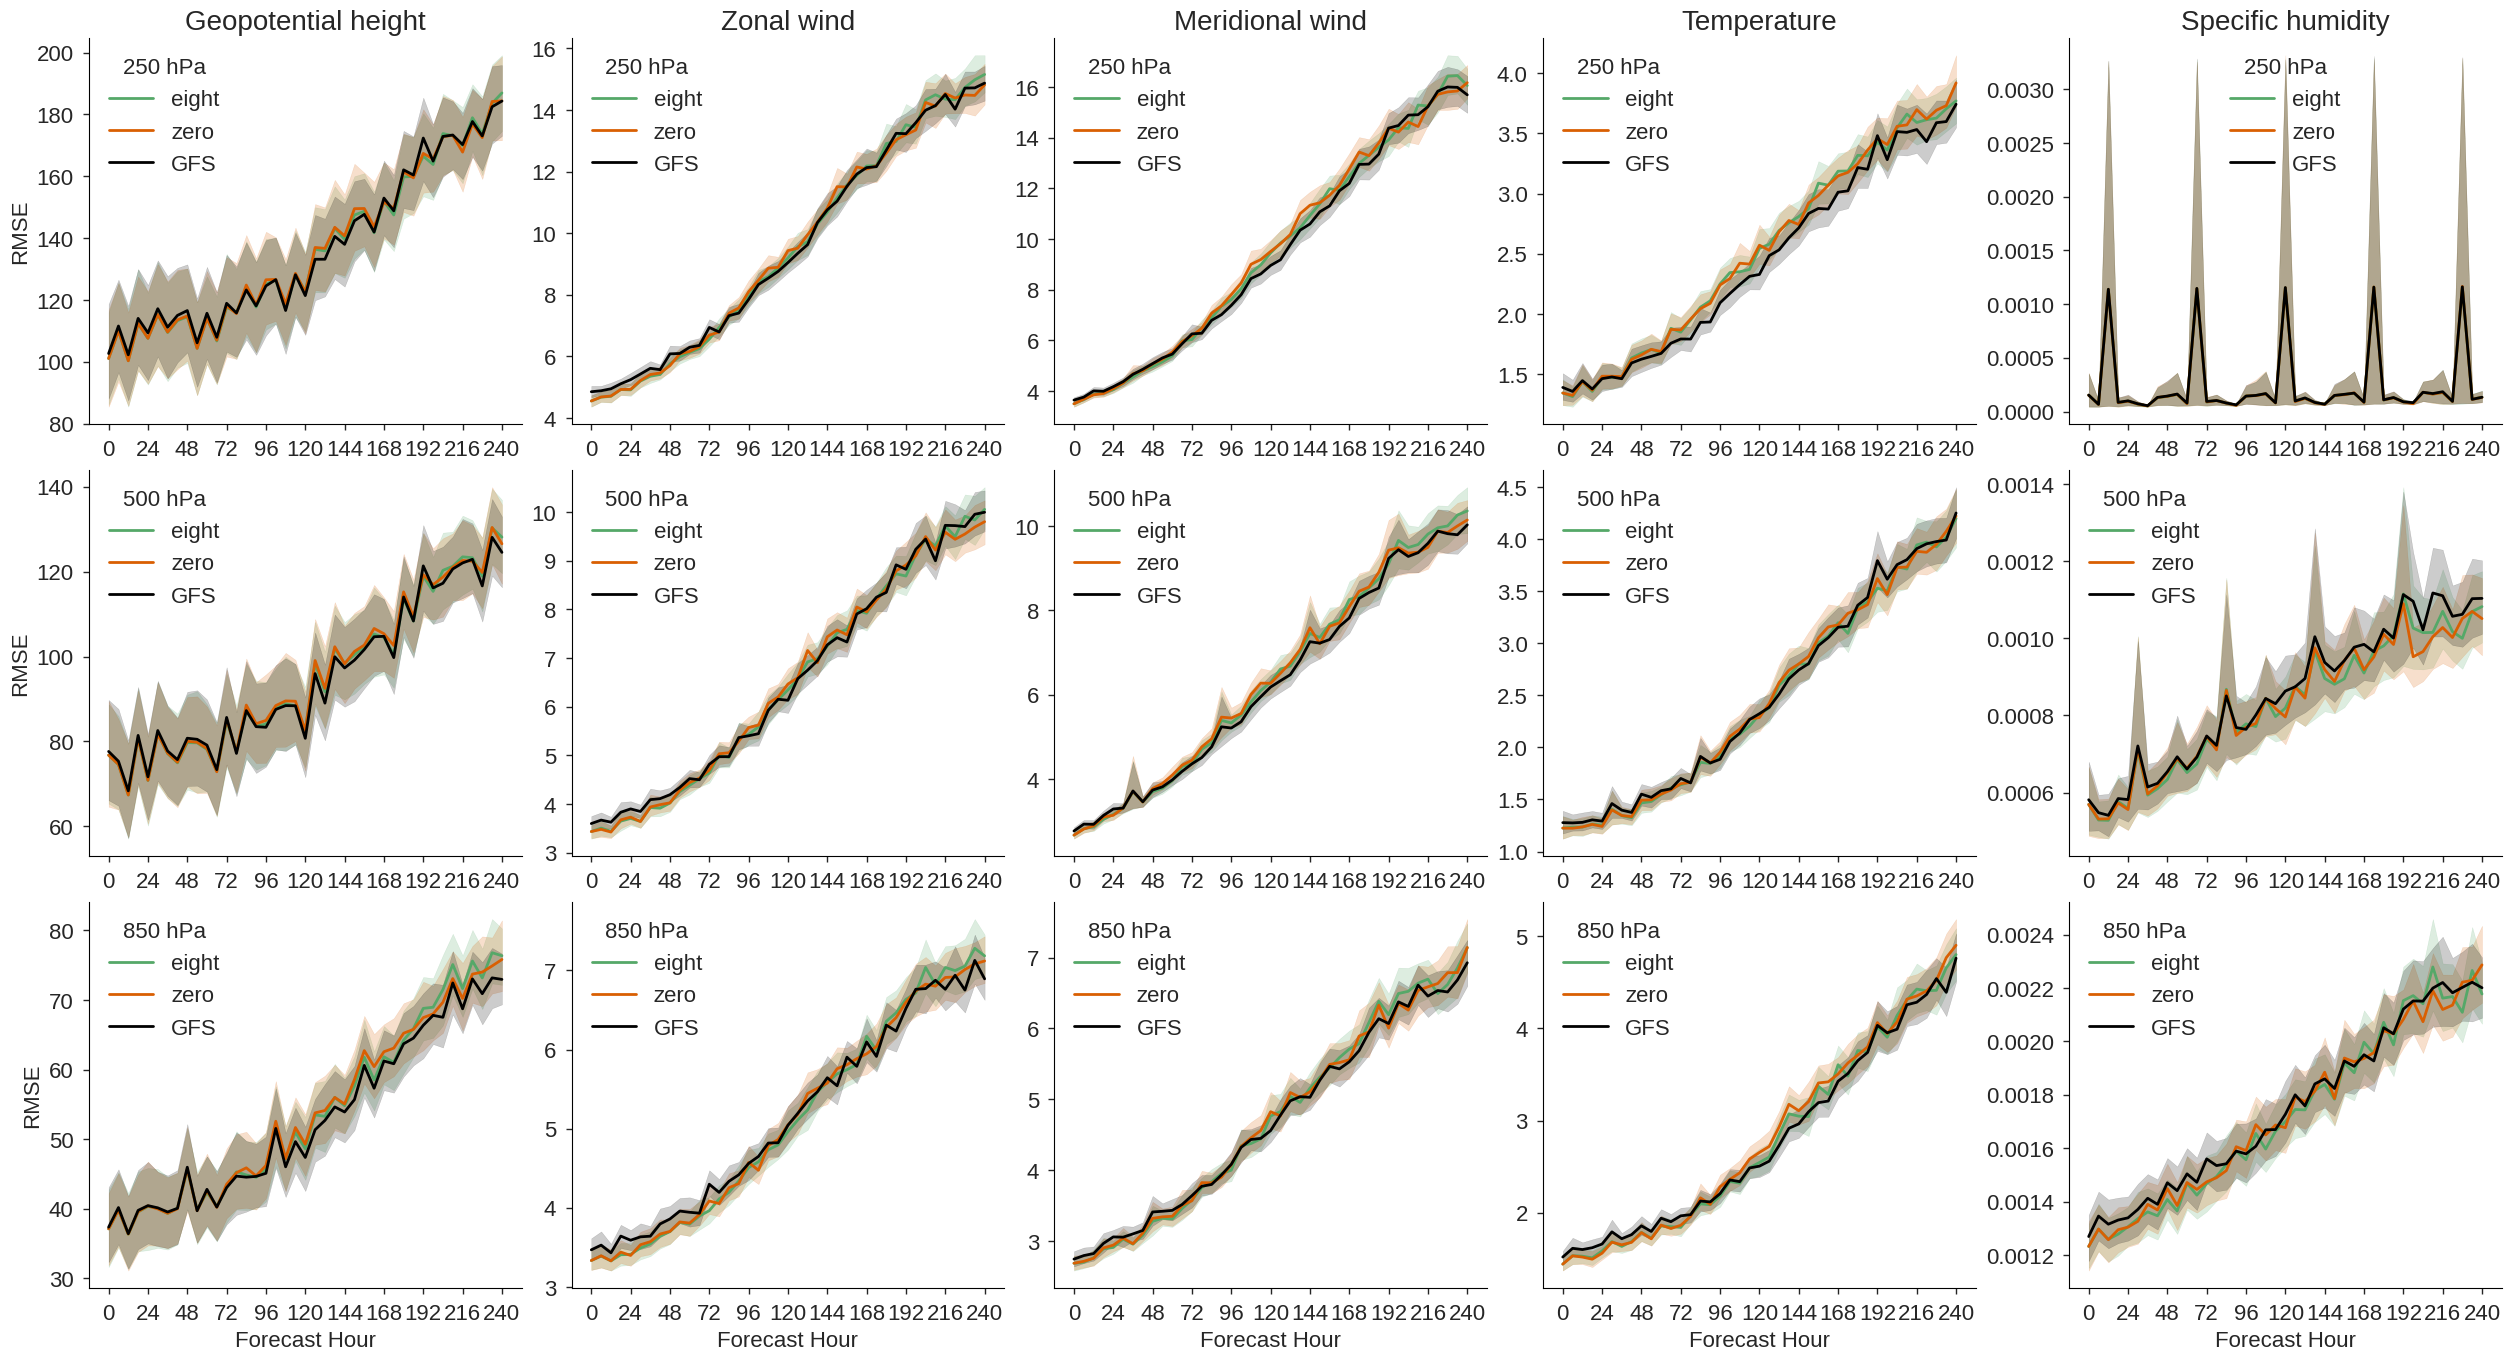

In [23]:
fig, axs = plot_level_vars(
    pressure_fields,
    dsdict=tp,
)